PA2A Part 1 <br>
Katherine Mantych <br>
2247750356 <br>

Support Functions for Problem 1

The generate synthetic data function was used to generate synthetic data cooresponding to the sepal width (worst feature) and petal length (best feature). I used min-max normalization to generate the data.

In [63]:
#generate synthetic data function. 
def generateSyntheticData(covMat, df):
    
    result_df = pd.DataFrame()
    
    m1 = np.random.randn(50,6)
    m2 = pd.DataFrame(covMat).to_numpy()
    rnd_data = m1.dot(m2)
    random_df = pd.DataFrame(data=rnd_data)

    def normalize(x):
        return (x - Pmin)/ (Pmax - Pmin) * (b-a) + a
   
    #Sepal width is the worst feature, so I selected it for the generated features
    
    a = df['sepal width'].min()
    b = df['sepal width'].max()

    Pmin = random_df[1].min()
    Pmax = random_df[1].max()
    
    #I only normalize once, more than once made the generated data too different than the original data
    result_df[0] = random_df[1].apply(normalize)
  
    #petallength is the best feature, so I selected that next
    a = df['petal length'].min()
    b = df['petal length'].max()

    Pmin = random_df[2].min()
    Pmax = random_df[2].max()
    
    result_df[1] = random_df[2].apply(normalize)
    
    return result_df

For finding outliers, I decided to use the Mahalanobis distance method because there are many features and their relationship to eachother should be taken into account.

In [65]:
#this function is used to find outliers using the mahalanobis distance
def mahalanobis2(inv_cov_mat, means_mat, obervation_mat):
    diff = np.subtract(obervation_mat, means_mat)
    diffT = np.transpose(diff)
    temp = np.matmul(diff, inv_cov_mat)
    return np.matmul(temp, diffT)[0]

In [66]:
def find_outliers(df, acr):
        
        indexes_of_outliers = []
        cov = df.cov()
        invcov = np.linalg.inv(cov)
        means_mat = np.transpose(pd.DataFrame(df.mean()).to_numpy())
        outliers = False
        for i in range (0, 50):
            if mahalanobis2(invcov, means_mat, df.iloc[i].to_numpy()) >= acr:
                print('outlier at index ' + str(i))
                indexes_of_outliers.append(i)
                outliers = True
            
        if outliers == False:
            print('no outliers found')
           
        del cov, invcov, means_mat
        return indexes_of_outliers

In [67]:
#alpha is assumed to be .05
#the result of this function is compared to the Mahalanobis distance to see if the oberservation is an outlier
def ACR(p,n):
    Fc = f.ppf(1-.05/n, p, n-p-1)
    return (p*(n-1)**2*Fc)/(n*(n-p-1)+(n*p*Fc))

In [68]:
import pandas as pd
import numpy as np
from statistics import mean 
from scipy.stats import f
import math

#for data cleansing, used to imput values into missing cells using kNN
from sklearn.impute import KNNImputer 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



#import iris_6_features_for_cleansing.csv
iris_df=pd.read_csv('iris_6_features_for_cleansing.csv')

#split into 3 dataframes, one for each class
grouped = iris_df.groupby('class')
class1_df = grouped.get_group(1)
del class1_df['class']
class2_df = grouped.get_group(2)
del class2_df['class']
class3_df = grouped.get_group(3)
del class3_df['class']

# compute test statistucs before inputting missing data

#find the covariance for each of the classes
iris_class_1_cov = class1_df.cov()
iris_class_2_cov = class2_df.cov()
iris_class_3_cov = class3_df.cov()

#find the mean for each of the classes
iris_class_1_means = np.mean(class1_df)
iris_class_2_means = np.mean(class2_df)
iris_class_3_means = np.mean(class3_df)

#find the min for each of the classes
iris_class_1_mins = np.min(class1_df)
iris_class_2_mins = np.min(class2_df)
iris_class_3_mins = np.min(class3_df)

#find the max for each of the classes
iris_class_1_maxs = np.max(class1_df)
iris_class_2_maxs = np.max(class2_df)
iris_class_3_maxs = np.max(class3_df)

#find the stdDev for each class
iris_class_1_stds = np.std(class1_df)
iris_class_2_stds = np.std(class2_df)
iris_class_3_stds = np.std(class3_df)

Below is the data with missing values

In [69]:
iris_df

,sepal length,sepal width,petal length,petal width,New Feature 1,New Feature 2,class
0,5.1,3.5,1.4,0.2,1.611281,2.981148,1
1,4.9,3.0,1.4,0.2,1.295847,2.210908,1
2,4.7,NaN,1.3,0.2,1.685578,3.114562,1
3,4.6,3.1,1.5,0.2,1.546064,2.714977,1
4,5.0,3.6,1.4,0.2,1.501464,2.815603,1
5,5.4,3.9,1.7,0.4,1.325835,2.235803,1
6,4.6,3.4,1.4,0.3,1.529386,2.792032,1
7,5.0,3.4,1.5,0.2,1.331028,2.278499,1
8,4.4,2.9,1.4,0.2,1.147873,1.976229,1
9,4.9,3.1,1.5,0.1,1.401505,2.434789,1


Problem 1 Part 1 - For data cleansing, I noticed that several values are missing for the data. I decided to use the kNN inputter method to replace the missing values because it is a better option than just using the mean for each class. Below is the updated data set with the new values

In [71]:
#Part 1 - data cleansing. Inputting missing values via kNN
array = iris_df.values
X = array[:, 0:6]
Y = array[:,6]

imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)

type(X)

cleaned_iris_df = pd.DataFrame(data=X, columns=["sepal length", "sepal width", "petal length", "petal width", "New Feature 1", "new feature 2"])# "generated sepal width", "generated petal length"])
cleaned_iris_df

,sepal length,sepal width,petal length,petal width,New Feature 1,new feature 2
0,5.100000,3.500000,1.400000,0.200000,1.611281,2.981148
1,4.900000,3.000000,1.400000,0.200000,1.295847,2.210908
2,4.700000,3.266667,1.300000,0.200000,1.685578,3.114562
3,4.600000,3.100000,1.500000,0.200000,1.546064,2.714977
4,5.000000,3.600000,1.400000,0.200000,1.501464,2.815603
5,5.400000,3.900000,1.700000,0.400000,1.325835,2.235803
6,4.600000,3.400000,1.400000,0.300000,1.529386,2.792032
7,5.000000,3.400000,1.500000,0.200000,1.331028,2.278499
8,4.400000,2.900000,1.400000,0.200000,1.147873,1.976229
9,4.900000,3.100000,1.500000,0.100000,1.401505,2.434789


Problem 1 Part 2 - Below I generate data abed on the sepal width (worst feature) and petal length (best feature). In the below cell, I check to see if the means and stds of the generated data are within an acceptable range by printing out a statement if they are not. I ran this cell several times and I noticed that frequently the std for class 1 generated data often lies outside of the desired range. I attempted to fix this my including a while loop that would stop when then conditions are met, but this often takes too long in real time and so i eliminated it. Overall, I consider the generated data to be "true" to the original data. 

In [73]:
#generate synthetic data
generated_data_class1 = generateSyntheticData(iris_class_1_cov, class1_df)
generated_data_class2 = generateSyntheticData(iris_class_2_cov, class2_df)
generated_data_class3 = generateSyntheticData(iris_class_3_cov, class3_df)


#veryify that data is true to original data means
generated_data_class1_means = np.mean(generated_data_class1)
generated_data_class2_means = np.mean(generated_data_class2)
generated_data_class3_means = np.mean(generated_data_class3)

#checking class 1 means
if(generated_data_class1_means[0] > iris_class_1_means[1]*1.2):
    print("generated data for sepel width class1 mean is too large")
if(generated_data_class1_means[0] < iris_class_1_means[1]*0.8):
    print("generated data for sepel width class 1 mean in too small")
    
if(generated_data_class1_means[1] > iris_class_1_means[2]*1.2):
    print("generated data from class1 means out of range too large")
if(generated_data_class1_means[1] < iris_class_1_means[2]*0.8):
    print("generated data from class1 means out of range too small")

#checking class 2 means
if(generated_data_class2_means[0] > iris_class_2_means[1]*1.2):
    print("generated data from class2 means out of range too large")
if(generated_data_class2_means[0] < iris_class_2_means[1]*0.8):
    print("generated data from class2 means out of range too small")
    
if(generated_data_class2_means[1] > iris_class_2_means[2]*1.2):
    print("generated data from class2 means out of range too large")
if(generated_data_class2_means[1] < iris_class_2_means[2]*0.8):
    print("generated data from class2 means out of range too small")   
    
#checking class 3 means
if(generated_data_class3_means[0] > iris_class_3_means[1]*1.2):
    print("generated data from class3 means out of range too large")
if(generated_data_class3_means[0] < iris_class_3_means[1]*0.8):
    print("generated data from class3 means out of range too small")
    
if(generated_data_class3_means[1] > iris_class_3_means[2]*1.2):
    print("generated data from class3 means out of range too large")
if(generated_data_class3_means[1] < iris_class_3_means[2]*0.8):
    print("generated data from class3 means out of range too small")
    
    

#veryify that data is true to original data stds
generated_data_class1_stds = np.std(generated_data_class1)
generated_data_class2_stds = np.std(generated_data_class2)
generated_data_class3_stds = np.std(generated_data_class3)

#checking class 1 stds
if(generated_data_class1_stds[0] > iris_class_1_stds[1]*1.2):
    print("generated data from class1 stds out of range too large")
if(generated_data_class1_stds[0] < iris_class_1_stds[1]*0.8):
    print("generated data from class1 stds out of range too small")
    
if(generated_data_class1_stds[1] > iris_class_1_stds[2]*1.2):
    print("generated data from class1 stds out of range too large")
if(generated_data_class1_stds[1] < iris_class_1_stds[2]*0.8):
    print("generated data from class1 stds out of range too small")

#checking class 2 stds
if(generated_data_class2_stds[0] > iris_class_2_stds[1]*1.2):
    print("generated data from class2 stds out of range too large")
if(generated_data_class2_stds[0] < iris_class_2_stds[1]*0.8):
    print("generated data from class2 stds out of range too small")
    
if(generated_data_class2_stds[1] > iris_class_2_stds[2]*1.2):
    print("generated data from class2 stds out of range too large")
if(generated_data_class2_stds[1] < iris_class_2_stds[2]*0.8):
    print("generated data from class2 stds out of range too small")   
    
#checking class 3 stds
if(generated_data_class3_stds[0] > iris_class_3_stds[1]*1.2):
    print("generated data from class3 stds out of range too large")
if(generated_data_class3_stds[0] < iris_class_3_stds[1]*0.8):
    print("generated data from class3 stds out of range too small")
    
if(generated_data_class3_stds[1] > iris_class_3_stds[2]*1.2):
    print("generated data from class3 stds out of range too large")
if(generated_data_class3_stds[1] < iris_class_3_stds[2]*0.8):
    print("generated data from class3 stds out of range too small")

gen_data = pd.concat([generated_data_class1, generated_data_class2, generated_data_class3], ignore_index = True)


gen_data = gen_data.rename(columns={0: "generated sepal width", 1: "genereated petal length"})
    
new_iris_data_8_features = pd.concat([cleaned_iris_df, gen_data], axis=1)


class_list = ([1] * 50) + ([2] * 50) + ([3] * 50)
new_iris_data_8_features.insert(8, "class_name", class_list, True)


generated data from class1 stds out of range too large
generated data from class1 stds out of range too large


Below is a table including the new generated data

In [74]:
new_iris_data_8_features

,sepal length,sepal width,petal length,petal width,New Feature 1,new feature 2,generated sepal width,genereated petal length,class_name
0,5.100000,3.500000,1.400000,0.200000,1.611281,2.981148,4.400000,1.633081,1
1,4.900000,3.000000,1.400000,0.200000,1.295847,2.210908,3.257991,1.556440,1
2,4.700000,3.266667,1.300000,0.200000,1.685578,3.114562,3.310081,1.527523,1
3,4.600000,3.100000,1.500000,0.200000,1.546064,2.714977,3.753743,1.555283,1
4,5.000000,3.600000,1.400000,0.200000,1.501464,2.815603,4.112857,1.674980,1
5,5.400000,3.900000,1.700000,0.400000,1.325835,2.235803,3.217092,1.380737,1
6,4.600000,3.400000,1.400000,0.300000,1.529386,2.792032,3.874680,1.496144,1
7,5.000000,3.400000,1.500000,0.200000,1.331028,2.278499,3.559711,1.425147,1
8,4.400000,2.900000,1.400000,0.200000,1.147873,1.976229,2.486381,1.181824,1
9,4.900000,3.100000,1.500000,0.100000,1.401505,2.434789,3.626438,1.264023,1


Problem 1 Part 3 - I removed outliers from the data set including the two generated features using mahalanobis distance.

In [75]:
#Part 3 - outlier removal - remove outliers from the set of 8 features

grouped = new_iris_data_8_features.groupby('class_name')
    #preprocessing c1, ppc2, ppc3
class1_df = grouped.get_group(1).reset_index()
ppc1 = class1_df
del ppc1['class_name']
class2_df = grouped.get_group(2).reset_index()
ppc2 = class2_df
del ppc2['class_name']
class3_df = grouped.get_group(3).reset_index()
ppc3 = class3_df
del ppc3['class_name']
ppc3
#determine if any otliers exist
print('for class 1')
class1_outliers = find_outliers(ppc1, ACR(8,50))
print('for class 2')
class2_outliers = find_outliers(ppc2, ACR(8,50))
print('for class 3')
class3_outliers = find_outliers(ppc3, ACR(8,50))


class1_removed_outliers = class1_df.drop(class1_outliers)
class2_removed_outliers = class2_df.drop(class2_outliers)
class3_removed_outliers = class3_df.drop(class3_outliers)


for class 1
outlier at index 43
for class 2
outlier at index 33
for class 3
no outliers found


Problem 1 Part 4 - I rank the set of all 8 features. Typically the generated petal length is the best feature. Generated sepal width is typically second to last. I clude a table below that lists the feature from best to worst and includes thier Chi squared score.

In [77]:
#Part 4 - rank the 6 set of features to determine which are the top two features. Can expand to all 8 
# Feature extraction
array = new_iris_data_8_features.values
X = array[:, 0:8]
Y = array[:,8]

test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(X, Y)

# Summarize scores
feature_ranking_list = pd.DataFrame(data=fit.scores_, index=["sepal length", "sepal width", "petal length", "petal width", "New Feature 1", "new feature 2", "generated sepal width", "generated petal length"], columns = ["score"])
feature_ranking_list = feature_ranking_list.sort_values(by=['score'], ascending=False)
feature_ranking_list

,score
generated petal length,127.944880
petal length,116.104390
petal width,67.179289
new feature 2,30.312636
sepal length,11.049501
generated sepal width,5.943174
sepal width,3.728849
New Feature 1,0.022716


Problem 1 Part 5 - for PCA i used build it functionality. I also decided to plot the results if I input all features, the best 3 features, and the worst three features. You can see that there is not a significant difference between using all 8 features vs the top 3. This is because since petal length and generated petal length are such good indicators of class that it dominates the results.

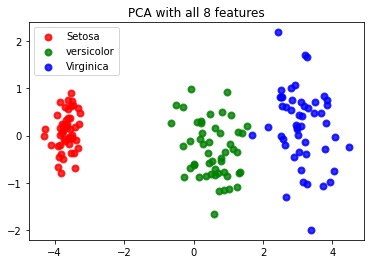

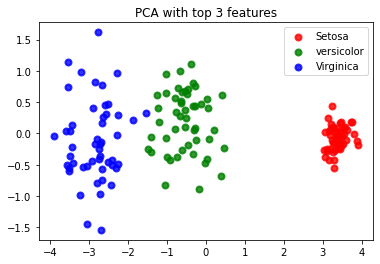

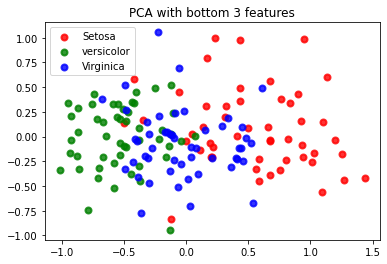

In [78]:
#Part 5 - PCA
array = new_iris_data_8_features.values
X = array[:, 0:8]
Y = array[:,8]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_temp = pca.transform(X)


plt.figure()
colors = ['red', 'green', 'blue']
flower_types = ['Setosa', 'versicolor', "Virginica"]


for color, i, flower_types in zip(colors, [1, 2, 3], flower_types):
    plt.scatter(X_temp[Y == i, 0], X_temp[Y == i, 1], color=color, alpha=.8, lw=2, label = flower_types)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA with all 8 features')
plt.show()


array = new_iris_data_8_features.values
X = array[:, [2,3,7]]
Y = array[:,8]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_temp = pca.transform(X)


plt.figure()
colors = ['red', 'green', 'blue']
flower_types = ['Setosa', 'versicolor', "Virginica"]


for color, i, flower_types in zip(colors, [1, 2, 3], flower_types):
    plt.scatter(X_temp[Y == i, 0], X_temp[Y == i, 1], color=color, alpha=.8, lw=2, label = flower_types)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA with top 3 features')
plt.show()

array = new_iris_data_8_features.values
X = array[:, [1,4,6]]
Y = array[:,8]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_temp = pca.transform(X)


plt.figure()
colors = ['red', 'green', 'blue']
flower_types = ['Setosa', 'versicolor', "Virginica"]


for color, i, flower_types in zip(colors, [1, 2, 3], flower_types):
    plt.scatter(X_temp[Y == i, 0], X_temp[Y == i, 1], color=color, alpha=.8, lw=2, label = flower_types)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA with bottom 3 features')
plt.show()

Problem 1 Part 6(a) - Bayes Classifier

In [79]:
#Part 6(a) - Bayes classifier
classifier_ranking_list = pd.DataFrame(index=["Bayes", "Fisher Linear Discriminant", "Neural Network", "SVM"], columns = ["misclassifications out of 75"])

#X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

pd.set_option('display.max_rows', 1000)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

classifier_ranking_list.at["Bayes","misclassifications out of 75"] = (y_test != y_pred).sum()

df_bayes = pd.DataFrame(X_test)
df_bayes['y_pred'] = y_pred
df_bayes[' real class'] = y_test
df_bayes = df_bayes.sort_values(by=['y_pred'])

Number of mislabeled points out of a total 75 points : 25


Problem 1 Part 6(b) - Fishers Linear Discriminent

In [80]:
#Part6(b) - Fisher's Linear discriminent

#X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
clf = LinearDiscriminantAnalysis()
y_pred = clf.fit(X_train, y_train).predict(X_test)

pd.set_option('display.max_rows', 1000)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

classifier_ranking_list.at["Fisher Linear Discriminant","misclassifications out of 75"] = (y_test != y_pred).sum()

df_fld = pd.DataFrame(X_test)
df_fld['y_pred'] = y_pred
df_fld[' real class'] = y_test
df_fld = df_fld.sort_values(by=['y_pred'])

Number of mislabeled points out of a total 75 points : 26


Problem 1 Part6(c) Neural Network

In [81]:
#Part6(c)
X, Y = make_classification(n_samples=150, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

FFNN = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = FFNN.fit(X_train, y_train).predict(X_test)

pd.set_option('display.max_rows', 1000)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

classifier_ranking_list.at["Neural Network","misclassifications out of 75"] = (y_test != y_pred).sum()

df_FFNN = pd.DataFrame(X_test)
df_FFNN['y_pred'] = y_pred
df_FFNN[' real class'] = y_test
df_FFNN = df_FFNN.sort_values(by=['y_pred'])

Number of mislabeled points out of a total 75 points : 15


Problem 1 Part 6(d) - SVM

In [82]:
#Part6(d) - SVM

array = new_iris_data_8_features.values
X = array[:, [1,4,6]]
Y = array[:,8]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
y_pred = svm.fit(X_train, y_train).predict(X_test)

pd.set_option('display.max_rows', 1000)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

classifier_ranking_list.at["SVM","misclassifications out of 75"] = (y_test != y_pred).sum()

df_svm = pd.DataFrame(X_test)
df_svm['y_pred'] = y_pred
df_svm[' real class'] = y_test
df_svm = df_svm.sort_values(by=['y_pred'])

Number of mislabeled points out of a total 75 points : 26


Summary of classification methods, Neural Network performed best at classifying the 8 feature data set.

In [83]:
#summary of classification methods
classifier_ranking_list = classifier_ranking_list.sort_values(by=['misclassifications out of 75'], ascending=True)
classifier_ranking_list


,misclassifications out of 75
Neural Network,15
Bayes,25
Fisher Linear Discriminant,26
SVM,26
